# Tutorial: Policy Gradient

**Resources**:
1. [Rich Sutton's RL Textbook (2nd edition draft)](https://drive.google.com/file/d/1xeUDVGWGUUv1-ccUMAZHJLej2C7aAFWY/view)
2. [The original REINFORCE paper by Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf) 
3. [David Silver's Policy Gradient Slides](http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/pg.pdf)
3. [Example Notebook using Policy Gradients with REINFORCEMENT to train an agent in a GridWorld environment (PyTorch)](https://github.com/spro/practical-pytorch/blob/master/reinforce-gridworld/reinforce-gridworld.ipynb)

## Change of Variables
The change of variables formula:

$p_X(x) = p_Z(z) \big|\det\frac{\partial x}{\partial z}\big|^{-1}$

$p_Z(z) = p_X(x) \big|\det\frac{\partial x}{\partial z}\big|$

**Example**:

Let $p(x) = 2x, 0 \leq x \leq 1$, and $z = f(x) = \sqrt{x}$

$\sqrt{x} = z \Leftrightarrow x = z^2$

$\frac{\partial x}{\partial z} = 2z$

$p_X(\textbf{x}) = p_Z(z) \bigg| \det \bigg( \frac{\partial \textbf{x}}{\partial z}\bigg) \bigg|^{-1} $

$p_Z(z) = p_X(\textbf{x}) \bigg| \det \bigg( \frac{\partial \textbf{x}}{\partial z}\bigg) \bigg| $

$p_Z(z) = (2x)| 2z |$

$p_Z(z) = (2(z^2))2z$

$p_Z(z) = 4z^3$

Let's try to visualize this!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import NullFormatter

We are going to plot 3 graphs: $p(x)$, $p(z)$, and $z = f(x) = \sqrt{x}$

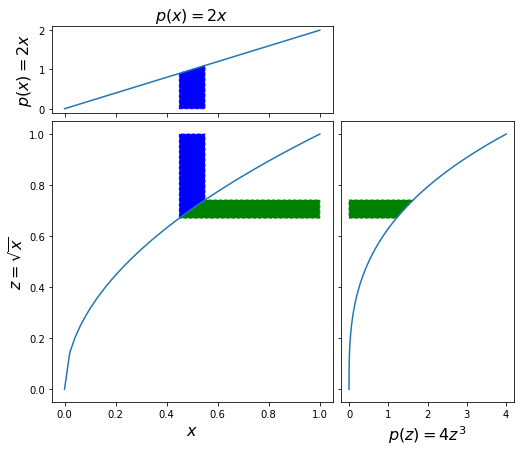

In [2]:
nullfmt = NullFormatter()         # no labels
plt.figure(1, figsize=(6, 6))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.4, height]

axFunc = plt.axes(rect_scatter)
axPX = plt.axes(rect_histx)
axPZ = plt.axes(rect_histy)

# no labels
axPX.xaxis.set_major_formatter(nullfmt)
axPZ.yaxis.set_major_formatter(nullfmt)

# Title the axes
axPX.set_title(r"$p(x) = 2x$", fontsize=16)
axPX.set_ylabel(r"$p(x) = 2x$", fontsize=16)
axPZ.set_xlabel(r"$p(z) = 4z^3$", fontsize=16)
axFunc.set_xlabel(r"$x$", fontsize=16)
axFunc.set_ylabel(r"$z = \sqrt{x}$", fontsize=16)

# Plot function
x = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)
axFunc.plot(x, np.sqrt(x))
axPX.plot(x, 2*x)
axPZ.plot(4*z**3, z)

# Plot a fill area
x_fill = np.linspace(0.45, 0.55, 3)
z_fill = np.sqrt(x_fill)
axPX.fill_between(x_fill, 2*x_fill, color='blue',linestyle='--')
axPZ.fill_betweenx(z_fill,4*z_fill**3, color='green',linestyle='--')
axFunc.fill_between(x_fill, z_fill, 1, color='blue', linestyle='--')
axFunc.fill_betweenx(z_fill, x_fill, 1, color='green', linestyle='--')
plt.show()

The blue area in the $p(x)$ graph above has the same area as the green area in the $p(z)$ graph on the right. 

## Policy Gradient Demo: Training Classifier with PG vs Gradient Descent

As seen in lecture, we can use REINFORCE as an alternative way to train a classifier. Instead of using cross-entropy and gradient descent, we can directly try to optimize the classification accuracy using REINFORCE. The set up looks like this (as shown in lec 21):

* state x: an image
* action a: a digit class
* reward r(x,a): 1 if correct, 0 if wrong
* policy pi(a|x): a distribution over categories

The difference between using REINFORCE versus Cross Entropy loss is that we need to sample the digit class, given the distribution over categories for a given image (state) at time $i$:

$\tilde{a_i} \sim \pi(a | x_i)$

And then apply the REINFORCE gradient estimator:

$ gradient = r(\tilde{a_i}, t_i) \frac{\partial}{\partial \theta} \log \pi_\theta (a_i | x_i)$

$ \theta \leftarrow \theta + \alpha * gradient$

In [3]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.special import expit

from autograd import grad
from autograd.misc.optimizers import adam
from autograd import elementwise_grad

import matplotlib.pyplot as plt
%matplotlib inline

# Generate some toy data
from sklearn.datasets import load_iris
iris = load_iris()

# print iris['DESCR']

color_wheel = {1: "#0392cf", 
               2: "#7bc043", 
               3: "#ee4035"}

sepal_len = iris['data'][:100,0]
sepal_wid = iris['data'][:100,1]
labels = iris['target'][:100]

# We will also center the data
# This is done to make numbers nice, so that we have no
# need for biases in our classification. (You might not
# be able to remove biases this way in general.)

sepal_len -= np.mean(sepal_len)
sepal_wid -= np.mean(sepal_wid)


We can plot the subset of data that we've chosen:

Text(0,0.5,'sepal width')

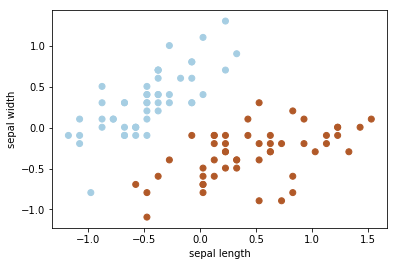

In [4]:
plt.scatter(sepal_len, 
            sepal_wid,
            c=labels,
            cmap=plt.cm.Paired)
plt.xlabel("sepal length")
plt.ylabel("sepal width")

In [5]:
def plot_sep(w1, w2, color='green'):
    '''
    Plot decision boundary hypothesis 
      w1 * sepal_len + w2 * sepal_wid = 0
    in input space, highlighting the hyperplane
    '''
    plt.scatter(sepal_len, 
                sepal_wid,
                c=labels,
                cmap=plt.cm.Paired)
    plt.title("Separation in Input Space")
    plt.ylim([-1.5,1.5])
    plt.xlim([-1.5,2])
    plt.xlabel("sepal length")
    plt.ylabel("sepal width")
    if w2 != 0:
        m = -w1/w2
        t = 1 if w2 > 0 else -1
        plt.plot(
            [-1.5,2.0], 
            [-1.5*m, 2.0*m], 
            '-y', 
            color=color)
        plt.fill_between(
            [-1.5, 2.0],
            [m*-1.5, m*2.0],
            [t*1.5, t*1.5],
            alpha=0.2,
            color=color)
    if w2 == 0: # decision boundary is vertical
        t = 1 if w1 > 0 else -1
        plt.plot([0, 0],
                 [-1.5, 2.0],
                 '-y',
                color=color)
        plt.fill_between(
            [0, 2.0*t],
            [-1.5, -2.0],
            [1.5, 2],
            alpha=0.2,
            color=color)

In [6]:
# A simple logistic classifier model
data = [(x,y) for x, y in zip(sepal_len, sepal_wid)]

def get_batch(data, labels, batch_size):
    choices = np.random.choice(len(data), batch_size, replace=False)
    return np.array(data)[choices], np.array(labels)[choices]

In [7]:
get_batch(data,labels, 10)

(array([[-0.571, -0.094],
        [ 0.229, -0.294],
        [-0.071,  0.306],
        [-0.071,  0.806],
        [ 0.329, -0.394],
        [ 0.929,  0.106],
        [ 0.529, -0.194],
        [-0.071,  0.806],
        [ 0.629, -0.294],
        [-0.471,  0.306]]), array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0]))

Text(0,0.5,'sepal width')

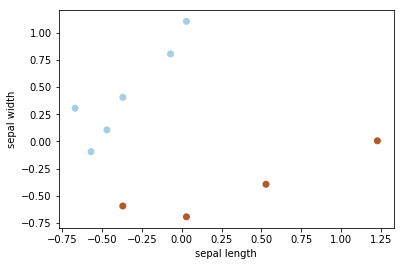

In [8]:
# Get a subset of the data and plot
data_batch, label_batch = get_batch(data,labels, 10)
plt.scatter(data_batch[:,0], 
            data_batch[:,1],
            c=label_batch,
            cmap=plt.cm.Paired)
plt.xlabel("sepal length")
plt.ylabel("sepal width")

In [9]:
# Version 1: Using binary cross-entropy and SGD
# Reference: https://github.com/HIPS/autograd/blob/master/docs/tutorial.md 
def sigmoid(x):
    return 0.5 * (np.tanh(x / 2.) + 1)

def logistic_predictions(weights, inputs):
    # Outputs probability of a label being true according to logistic model.
    return sigmoid(np.dot(inputs, weights))

def bce_training_loss(weights, inputs, targets):
    # Training loss is the negative log-likelihood of the training labels.
    preds = logistic_predictions(weights, inputs)
    label_probabilities = preds * targets + (1 - preds) * (1 - targets)
    return -np.mean(np.log(label_probabilities))

('Initial loss:', 0.6931471805599453)
Weights: [ 0.000855 -0.00303 ], ce loss: 0.692156479291
Weights: [ 0.0340743  -0.00763141], ce loss: 0.679698736715
Weights: [ 0.0485318  -0.03333809], ce loss: 0.680038089181
Weights: [ 0.06976188 -0.04276592], ce loss: 0.667399038146
Weights: [ 0.09125719 -0.05633454], ce loss: 0.676695833047
Weights: [ 0.10582036 -0.07824413], ce loss: 0.647013186527
Weights: [ 0.13920815 -0.08978831], ce loss: 0.613768389594
Weights: [ 0.17614595 -0.09266677], ce loss: 0.663968924237
Weights: [ 0.19693307 -0.10913744], ce loss: 0.579831248138
Weights: [ 0.2213553  -0.12501762], ce loss: 0.624426936135
('Trained loss:', 0.6455490342752355)
[ 0.24780465 -0.1302439 ]


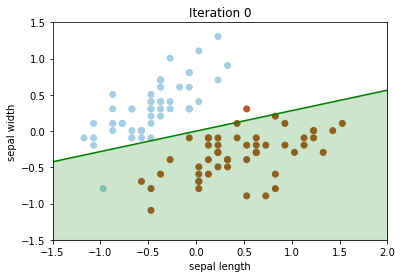

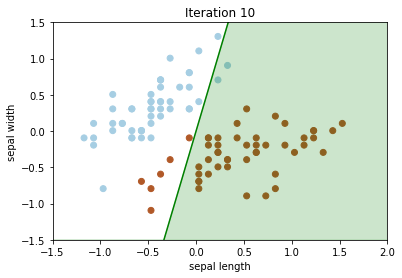

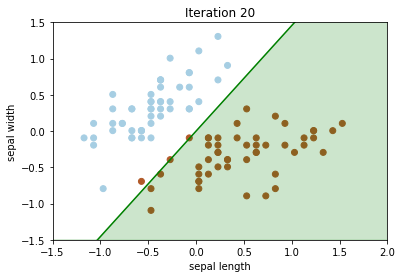

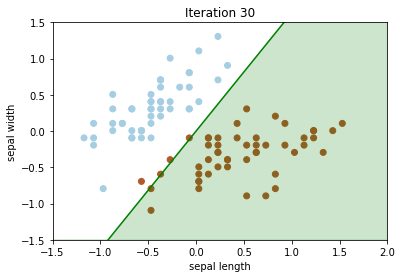

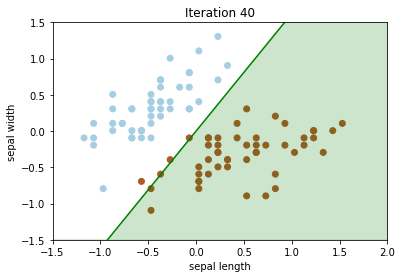

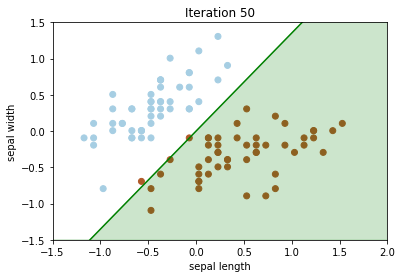

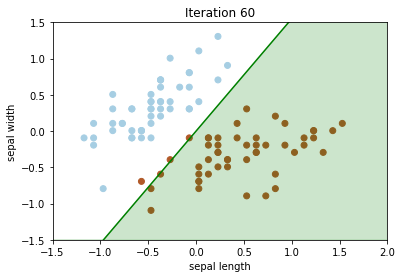

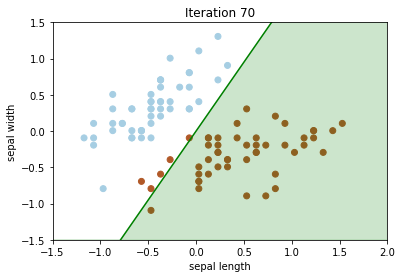

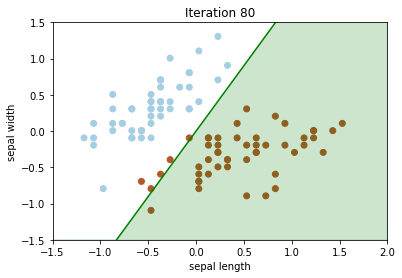

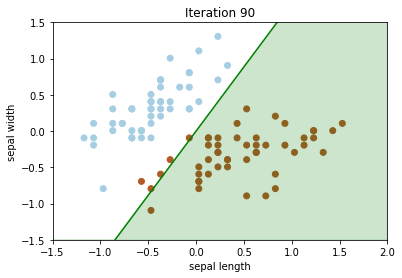

In [10]:
# Define a function that returns gradients of training loss using Autograd.
training_gradient_fun = grad(bce_training_loss)

lr = 0.01
weights = np.array([0.0, 0.0])
batch_size = 1
data_batch, label_batch = get_batch(data, labels, batch_size)
ce_loss_list = []
iterations = []
num_it = 100

print("Initial loss:", bce_training_loss(weights, data_batch, label_batch))
ce_loss_list.append(bce_training_loss(weights, data_batch, label_batch))
iterations.append(0)
for i in range(num_it):
    data_batch, label_batch = get_batch(data, labels, batch_size)
    weights -= training_gradient_fun(weights, data_batch, label_batch) * lr
    if i % 10 == 0:
        print "Weights: {}, ce loss: {}".format(weights, bce_training_loss(weights, data_batch, label_batch))
        plt.figure()
        plot_sep(weights[0], weights[1], color='green')
        plt.title("Iteration {}".format(i))
        ce_loss_list.append(bce_training_loss(weights, data_batch, label_batch))
        iterations.append(i+1)
print("Trained loss:", bce_training_loss(weights, data_batch, label_batch))
print weights

In [11]:
# Version 2: REINFORCE version of the training using classification accuracy
def logit(x):
    """Inverse of sigmoid: log(x / (1- x))
    """
    return np.log(x) - np.log(1-x)

# Fast Sigmoid: https://timvieira.github.io/blog/post/2016/07/04/fast-sigmoid-sampling/
def sample_sigmoid(x, noise):
    """ Assume x is batch_size * 1. 
    Return batch_size * 1 sample where the probability of ith row = 1 is given by x[i]
    
    Does u ~ uniform(0,1), out = x > logit(u)
    """
    z = logit(noise)
    return np.array(x > z, dtype=np.int64)

def log_sigmoid_predictions(weights, inputs, noise):
    prob = sigmoid(np.dot(inputs, weights))
    prediction = sample_sigmoid(prob, noise)
    return np.log(prediction*prob + (1-prediction)*(1-prob))

def funcval_log_sigmoid_predictions(weights, inputs, noise, func_val):
    log_sig_pred = log_sigmoid_predictions(weights, inputs, noise)
    return func_val * log_sig_pred

def classification_acc(weight, inputs, targets, noise):
    prob = sigmoid(np.dot(inputs, weights))
    prediction = sample_sigmoid(prob, noise)
    return np.array(prediction == targets, dtype=np.int64)

# Derivative of a sigmoid wrt input z: https://math.stackexchange.com/questions/2320905/obtaining-derivative-of-log-of-sigmoid-function
def grad_log_sigmoid_predictions(weights, inputs, noise):
    z = np.dot(inputs, weights)
    prob = sigmoid(z)
    prediction = sample_sigmoid(prob, noise)
    d_log_sigmoid_pred_dz = ((prediction)*(np.exp(-np.maximum(z,0))/(np.exp(z-np.maximum(z,0)) + np.exp(-np.maximum(z,0)))) + (1-prediction)*(np.exp(z-np.maximum(z,0))/(np.exp(z-np.maximum(z,0)) + np.exp(-np.maximum(z,0)))))
    return np.sum(np.expand_dims(d_log_sigmoid_pred_dz, axis=1)*(inputs), axis=0)

def REINFORCE(weight, inputs, targets, noise):
    prob = sigmoid(np.dot(inputs, weights))
    samples = sample_sigmoid(prob, noise)
    func_vals = classification_acc(weight, inputs, targets, noise)
    reinforce_grad = elementwise_grad(funcval_log_sigmoid_predictions)(weights, inputs, noise, func_vals)/inputs.shape[0]
    
    # Alternative: Pure python without using autograd. Implement own 
#     reinforce_grad = np.expand_dims(func_vals, axis=1) * grad_log_sigmoid_predictions(weights, inputs, noise)
    
    return reinforce_grad
    

('Initial Classification Error:', 0.0)
weights: [0. 0.], classification error: 0.0, ce loss: 0.69314718056
weights: [ 0.001855 -0.00353 ], classification error: 1.0, ce loss: 0.691558252416
weights: [ 0.01603292 -0.00458606], classification error: 1.0, ce loss: 0.68961440351
weights: [ 0.03127543 -0.00810425], classification error: 0.0, ce loss: 0.675377067057
weights: [ 0.03609742 -0.01699525], classification error: 1.0, ce loss: 0.694691507808
weights: [ 0.05418392 -0.02096945], classification error: 1.0, ce loss: 0.678941620984
weights: [ 0.07526975 -0.03448783], classification error: 1.0, ce loss: 0.658446065952
weights: [ 0.08874398 -0.04083816], classification error: 0.0, ce loss: 0.657773983599
weights: [ 0.10481852 -0.04417893], classification error: 0.0, ce loss: 0.657382778382
weights: [ 0.12030549 -0.05194805], classification error: 1.0, ce loss: 0.668258907264
weights: [ 0.1272702  -0.05146521], classification error: 0.0, ce loss: 0.631848960901
('Trained loss:', 0.65142039

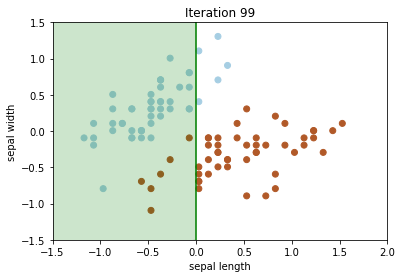

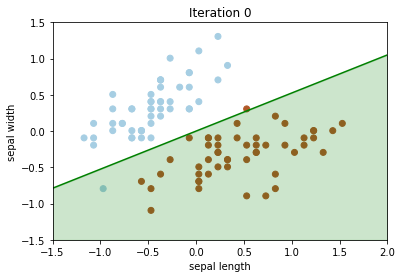

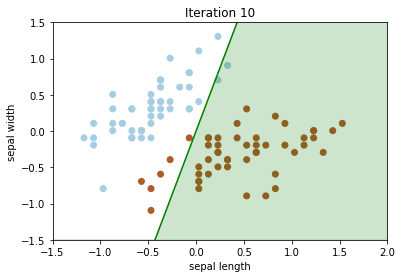

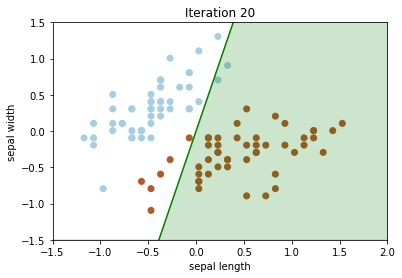

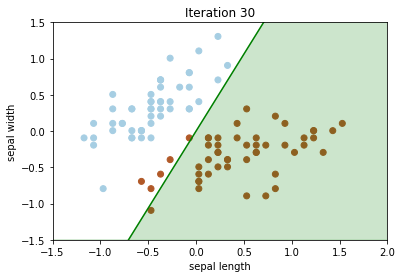

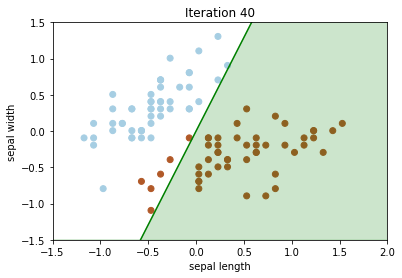

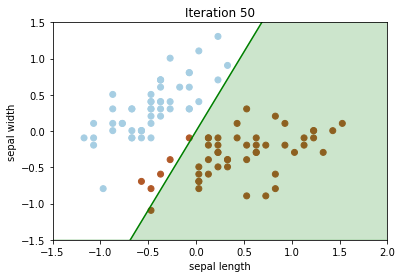

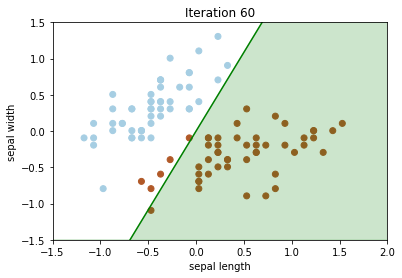

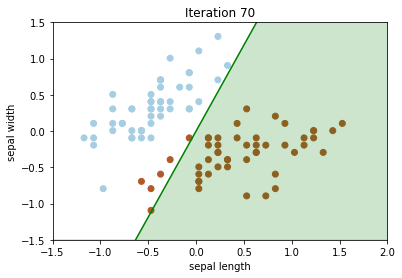

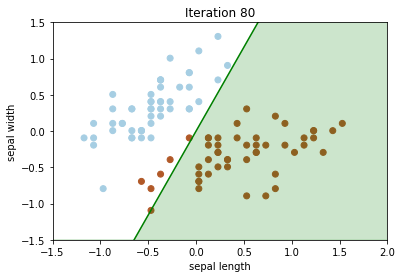

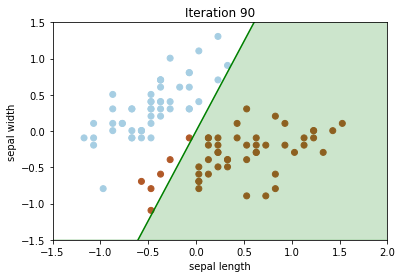

In [12]:
lr = 0.01
weights = np.array([0.0, 0.0])
batch_size = 1
data_batch, label_batch = get_batch(data, labels, batch_size)
out = logistic_predictions(weights, data_batch)

data_batch, label_batch = get_batch(data, labels, batch_size)
noise_u = np.random.uniform(0,1,size=label_batch.shape)
print("Initial Classification Error:", np.mean(classification_acc(weights, data_batch, label_batch, noise_u)))
print "weights: {}, classification error: {}, ce loss: {}".format(weights, np.mean(classification_acc(weights, data_batch, label_batch, noise_u)),bce_training_loss(weights, data_batch, label_batch))
rl_ce_loss_list = []
rl_ce_loss_list.append(bce_training_loss(weights, data_batch, label_batch))
plt.figure()
plot_sep(weights[0], weights[1], color='green')
plt.title("Iteration {}".format(i))
for i in range(num_it):
    data_batch, label_batch = get_batch(data, labels, batch_size)
    noise_u = np.random.uniform(0,1,size=label_batch.shape)
    reinforce_grad = REINFORCE(weights, data_batch, label_batch, noise_u)
    weights += reinforce_grad*lr
    if i % 10 == 0:
        print "weights: {}, classification error: {}, ce loss: {}".format(weights, np.mean(classification_acc(weights, data_batch, label_batch, noise_u)),bce_training_loss(weights, data_batch, label_batch))
        plt.figure()
        plot_sep(weights[0], weights[1], color='green')
        plt.title("Iteration {}".format(i))
        rl_ce_loss_list.append(bce_training_loss(weights, data_batch, label_batch))
print("Trained loss:", bce_training_loss(weights, data_batch, label_batch))
print weights

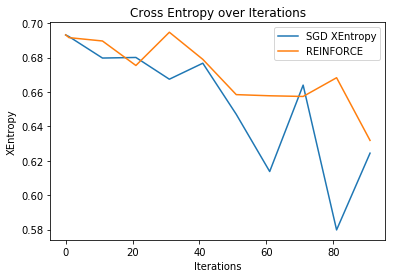

In [13]:
# Plot CE with SGD vs REINFORCE
plt.figure()
plt.plot(iterations, ce_loss_list, label="SGD XEntropy")
plt.plot(iterations, rl_ce_loss_list, label="REINFORCE")
plt.ylabel("XEntropy")
plt.xlabel("Iterations")
plt.title("Cross Entropy over Iterations")
plt.legend()

**Exercise**: Try with baseline: modify `classification_acc` to have baseline: `reward = [pred == target] + 10`